# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**Цель проекта**:
Опираясь на критерии заказчика, выбрать лучшую модель, проверить её качество на тестовой выборке.

**План проекта**
- Задача 1: предсказание уровня удовлетворённости сотрудника
 1. Подготовка данных.
 2. Обучение моделей.
 3. Анализ моделей.
 4. Вывод
 5. Чек-лист проверки

In [1]:
#установка версий библиотек 

!pip install phik -q

In [2]:
import pandas as pd

import seaborn as sns

from matplotlib import pyplot as plt

import numpy as np

import time

import phik
from phik.report import plot_correlation_matrix

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler, OrdinalEncoder

from sklearn.metrics import mean_squared_error

from sklearn.tree import DecisionTreeRegressor

from sklearn.model_selection import GridSearchCV

from lightgbm import LGBMRegressor

from catboost import CatBoostRegressor

## Подготовка данных

Загрузите данные.
Изучите данные. Заполните пропущенные значения и обработайте аномалии в столбцах. Если среди признаков имеются неинформативные, удалите их.

### Обработка данных

In [3]:
#считаем данные и загрузим в датафрейм
autos_data = pd.read_csv('autos.csv')

In [4]:
# выведем общее инфо
autos_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [5]:
#запишем изначальный размер датасета
len_0 = len(autos_data)

In [6]:
autos_data.head(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


Видим, что есть пропуски в пяти столбцах, типы данных соотвествуют ожидаемым. Названия стобцов не соответствуют правилам. 

In [7]:
#приведем названия столбцов к змеиному регистру
autos_data.columns = autos_data.columns.str.replace(r"([A-Z])", r" \1", regex=True)\
                                       .str.replace('(?<=.) ', '_', regex=True)\
                                       .str.replace(' ', '', regex=True)\
                                       .str.lower()

In [8]:
#выведем долю пропусков в каждом признаке
for l in autos_data.columns:
    print(f'Процент пропусков в признаке {l} = {autos_data[l].isna().mean():.2%}')

Процент пропусков в признаке date_crawled = 0.00%
Процент пропусков в признаке price = 0.00%
Процент пропусков в признаке vehicle_type = 10.58%
Процент пропусков в признаке registration_year = 0.00%
Процент пропусков в признаке gearbox = 5.60%
Процент пропусков в признаке power = 0.00%
Процент пропусков в признаке model = 5.56%
Процент пропусков в признаке kilometer = 0.00%
Процент пропусков в признаке registration_month = 0.00%
Процент пропусков в признаке fuel_type = 9.28%
Процент пропусков в признаке brand = 0.00%
Процент пропусков в признаке repaired = 20.08%
Процент пропусков в признаке date_created = 0.00%
Процент пропусков в признаке number_of_pictures = 0.00%
Процент пропусков в признаке postal_code = 0.00%
Процент пропусков в признаке last_seen = 0.00%


In [9]:
#просмотрим уникальные значения в столбцах с пропусками
subset = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'repaired']
for l in subset:
    print(autos_data[l].value_counts())
    print('\n')

sedan          91457
small          79831
wagon          65166
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288
Name: vehicle_type, dtype: int64


manual    268251
auto       66285
Name: gearbox, dtype: int64


golf                  29232
other                 24421
3er                   19761
polo                  13066
corsa                 12570
                      ...  
serie_2                   8
rangerover                4
serie_3                   4
serie_1                   2
range_rover_evoque        2
Name: model, Length: 250, dtype: int64


petrol      216352
gasoline     98720
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: fuel_type, dtype: int64


no     247161
yes     36054
Name: repaired, dtype: int64




Поставим заглушки на пропуски в столбцах, для дальнейшего анализа

In [10]:
autos_data = autos_data.fillna('unknown')

Заменим тип топлива gasoline на petrol, так как это один и тот же вид топлива

In [11]:
autos_data['fuel_type'] = autos_data['fuel_type'].replace('gasoline', 'petrol')

### Исследовательский анализ данных

In [12]:
autos_data.describe().T

,count,mean,std,min,25%,50%,75%,max
price,354369.0,4416.656776,4514.158514,0.0,1050.0,2700.0,6400.0,20000.0
registration_year,354369.0,2004.234448,90.227958,1000.0,1999.0,2003.0,2008.0,9999.0
power,354369.0,110.094337,189.850405,0.0,69.0,105.0,143.0,20000.0
kilometer,354369.0,128211.172535,37905.341530,5000.0,125000.0,150000.0,150000.0,150000.0
registration_month,354369.0,5.714645,3.726421,0.0,3.0,6.0,9.0,12.0
number_of_pictures,354369.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
postal_code,354369.0,50508.689087,25783.096248,1067.0,30165.0,49413.0,71083.0,99998.0


Можно отметить, что в столбце с количеством фотографий одно значение - 0, этот признак можно удалить. 
Такие признаки, как  дата последней активности пользователя, почтовый индекс пользователя, месяц регистрации и дата создания анкеты не влияют на стоимость машины - также удалим их из датасета

In [13]:
autos_data = autos_data.drop(
    [
        'registration_month', 
        'date_created', 
        'number_of_pictures', 
        'postal_code', 
        'last_seen'
    ], axis = 1
)

In [17]:
#создадим функцию для построения графиков распределения количественных признаков
def graph_maker_num(df, col_names, labels):
    for i, col_name in enumerate(col_names):
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
        df[col_name].plot(kind='hist', bins=10, ax=axes[0])
        axes[0].set_title(f'Гистограмма распределения, {col_name}')
        axes[0].set_xlabel(f'{labels[i]}')
        axes[0].set_ylabel('Количество сотрудников')
        df[col_name].plot(kind='box', ax=axes[1], vert=False)
        axes[1].set_title(f'Разброс значений признаков, {col_name}')
        axes[1].set_xlabel(f'{labels[i]}')
        axes[1].set_yticks([])
        plt.show()

In [18]:
#создадим список значений количественных признаков
num_col_names_1 = autos_data.select_dtypes(include='number').columns.tolist()

In [19]:
#создадим список подписей для графиков
num_labels = [
    'Цена (евро)',
    'Год регистрации автомобиля',
    'Мощность (л.с.)',
    'Пробег (км)'
]

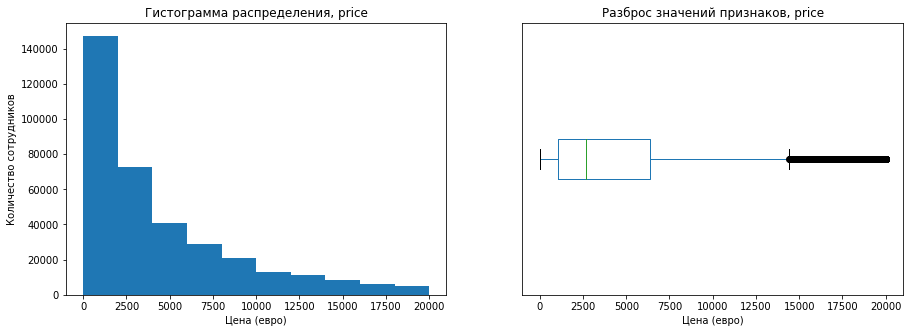

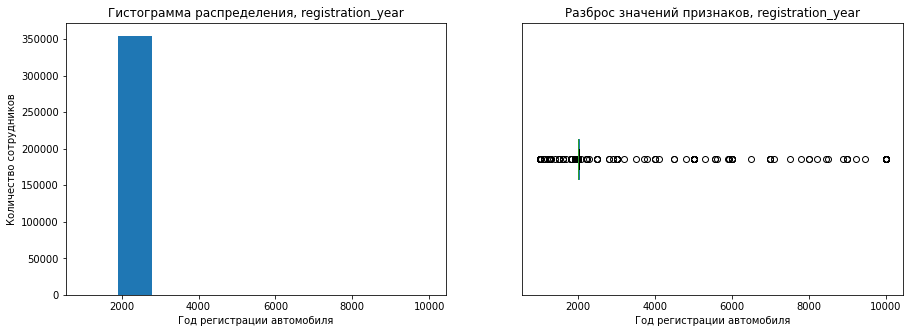

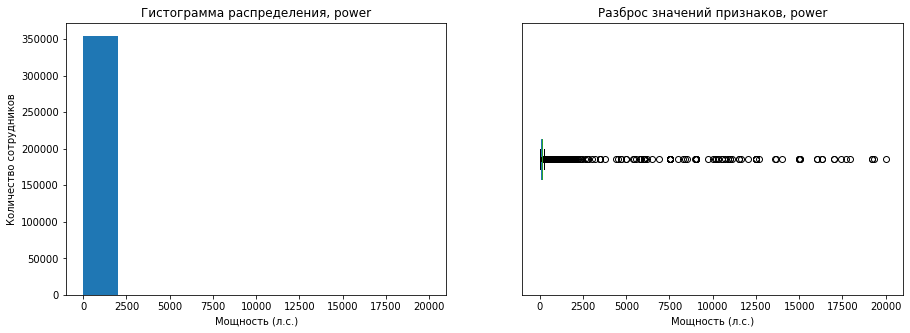

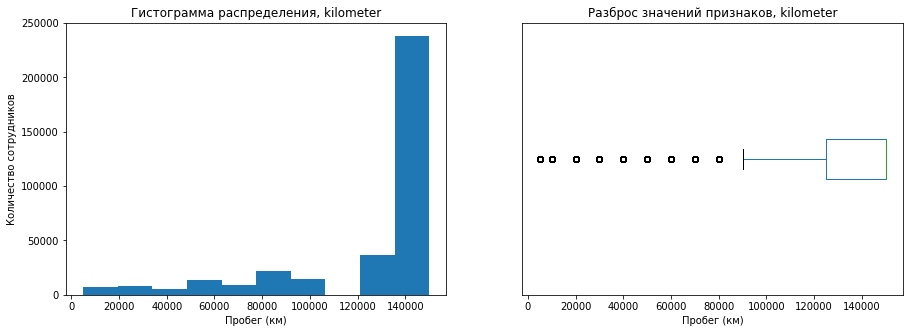

In [20]:
#построим графики распределения количественных признаков
graph_maker_num(autos_data, num_col_names_1, num_labels)

Можно отметить наличие нулевых значений в цене автомобиля - проверим количество таких значений

In [21]:
autos_data.describe().T

,count,mean,std,min,25%,50%,75%,max
price,354369.0,4416.656776,4514.158514,0.0,1050.0,2700.0,6400.0,20000.0
registration_year,354369.0,2004.234448,90.227958,1000.0,1999.0,2003.0,2008.0,9999.0
power,354369.0,110.094337,189.850405,0.0,69.0,105.0,143.0,20000.0
kilometer,354369.0,128211.172535,37905.341530,5000.0,125000.0,150000.0,150000.0,150000.0


In [22]:
print(f'{len(autos_data[autos_data["price"] == 0])/len_0:.2%}')

3.04%


Удалим данные с нулевой ценой, так как они занимают всего 3 процента от начального объема данных

In [23]:
autos_data = autos_data[autos_data["price"] > 0]

Проверим данные с около-нулевыми ценами

In [24]:
autos_data[autos_data["price"] <100]['power'].value_counts()

0       1298
75       135
60       109
45        72
90        66
        ... 
430        1
400        1
10         1
320        1
1401       1
Name: power, Length: 166, dtype: int64

Видим, что год регистрации начинается с 1000 и заканчивается 9999. По общим данным машины признаны винтажными до с годом выпуска примерно до 1930 - для этих машин ценовые категории идут в других рамках, чем для коммерческих автомобилей - поэтому отфильтруем данные с 1930 до времени сбора данных

Проверим по датам выгрузки анкет верхнюю границу года регистрации

In [25]:
autos_data['date_crawled'].min()

'2016-03-05 14:06:22'

In [26]:
autos_data['date_crawled'].max()

'2016-04-07 14:36:58'

Возьмем за верхнюю границу даты регистрации 2016 год

In [27]:
autos_data = autos_data.query('registration_year > 1930 & registration_year < 2016')

Значения для мощности в датасете начинаются с 0 и заканчиваются 20000 - по общим данным, в среднем минимальная мощность для автомобиля - 60 лс и максимальная около 400 лс. Избавимся от значений с минимальными стоимостями и нулевой мощность. Заменим все некорректные данные медианой. 

In [28]:
autos_data = autos_data.query('power !=0 and price >99')

In [29]:
med =  autos_data['power'].median()

In [30]:
autos_data['power'] = np.where((autos_data['power'] < 60) | (autos_data['power'] > 400), med, autos_data['power'])

Данные по пробегу не являются аномальными, оставим их без изменений

In [31]:
#проверим данные на дубликаты
autos_data.duplicated().sum()

25

In [32]:
#удалим дубликаты
autos_data = autos_data.drop_duplicates()

Удалим оставшийся неинформативный признак "дата выгрузки анкеты"

In [33]:
autos_data = autos_data.drop(['date_crawled'], axis = 1)

In [34]:
#проверим признаки на мультиколлинеарность
phik_overview = autos_data.phik_matrix(interval_cols=['price', 'power'], bins={'price':50, 'power':50})

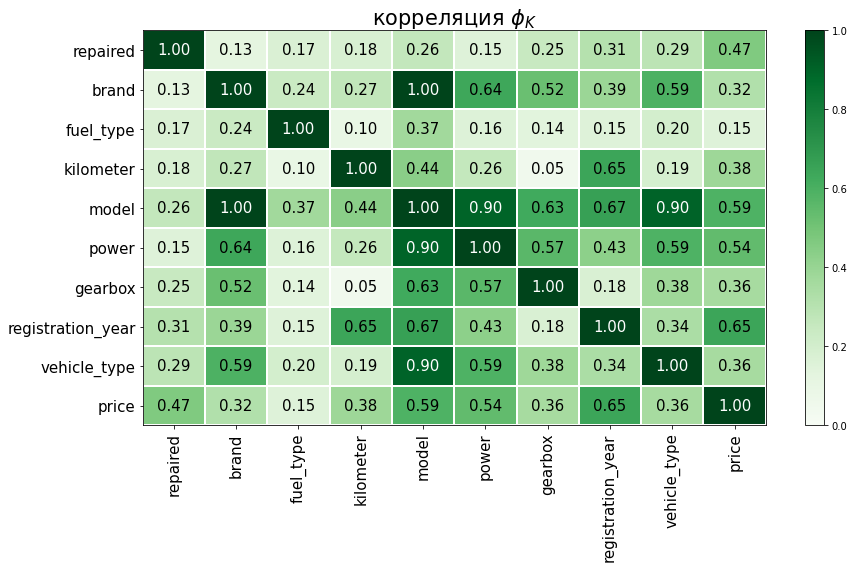

In [35]:
#построим матрицу корреляции
plot_correlation_matrix(
    phik_overview.values,
    x_labels = phik_overview.columns,
    y_labels = phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'корреляция $\phi_K$',
    fontsize_factor=1.5,
    figsize=(13,8)
    
)

In [36]:
autos_data['model'] = autos_data['brand'] + '_' + autos_data['model']

In [37]:
autos_data = autos_data.drop(['brand'], axis=1)

In [38]:
#проверим объем удаленных данных
len(autos_data)/len_0

0.8165245831322717

### Вывод

Изучив данные, обнаружили пропуски в пяти столбцах. На пропуски поставлена заглушка для последующего анализа. Аномальные нулевые значения в столбцах со значениями цены были устранены, выбросы в столбце с мощностью заменили на медиану значений, отфильтровали данные по значению года регистрации - удалили очень старые или слишком новые по году выпуска машины  

Удалили неинформативные и не влияющие на стоимость машины признаки со значениями количества фотографий, даты скачивания анкеты из базы, даты последней активности пользователя, почтового индекс пользователя, месяца регистрации и даты создания анкеты.

Признаки бренд и модель машины объединили, так как они были мультиколлинеарными. 

Удалили дубликаты данных.

Общий объем удаленных данных 18,3%

## Обучение моделей

Подготовьте выборки для обучения моделей.
Обучите разные модели, одна из которых — LightGBM, как минимум одна — не бустинг. Для каждой модели попробуйте разные гиперпараметры.
Проанализируйте время обучения, время предсказания и качество моделей.
Опираясь на критерии заказчика, выберите лучшую модель, проверьте её качество на тестовой выборке.

Для оценки качества моделей применяйте метрику RMSE.

Значение метрики RMSE должно быть меньше 2500.

Самостоятельно освойте библиотеку LightGBM и её средствами постройте модели градиентного бустинга.

### Подготовка к обучению

In [39]:
#подготовим список количественных признаков
num_col_names = autos_data.select_dtypes(include='number').columns.tolist()[1:]

In [40]:
#подготовим список качественных признаков
cat_col_names = autos_data.select_dtypes(exclude='number').columns.tolist()

In [41]:
RANDOM_STATE = 42
# выделяем в отдельные переменные целевой признак и входные признаки
X = autos_data.drop(['price'], axis=1)
y = autos_data['price']
 

In [42]:
#разделим выборку на тестовую и тренировочную   
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    random_state=RANDOM_STATE
)

Масштабируем количественные признаки с помощью StandardScaler

In [43]:
#создаем переменную с экземпляром класса StandardScaler()
scaler = StandardScaler()

#обучим и трансформируем количественные признаки из тренировочной выборки 
X_train_scaled = scaler.fit_transform(X_train[num_col_names])

#выполним преобразование количественных признаков в тестовой выборке
X_test_scaled = scaler.transform(X_test[num_col_names])

Кодируем категориальные признаки с помощью OrdinalEncoder.

In [44]:
#создаем переменную с экземпляром класса OrdinalEncoder()
encoder = OrdinalEncoder(handle_unknown='most_frequent')

#обучим и трансформируем категориальные признаки из тренировочной выборки 
X_train_oe = encoder.fit_transform(X_train[cat_col_names])

#выполним преобразование категориальных признаков в тестовой выборке
X_test_oe = encoder.transform(X_test[cat_col_names])

In [45]:
X_train_oe = pd.DataFrame(X_train_oe, columns=cat_col_names)
X_test_oe = pd.DataFrame(X_test_oe, columns=cat_col_names)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)
    
X_train = pd.concat([X_train_oe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_oe, X_test_scaled], axis=1)

### Дерево решений

In [46]:
#инициализируем модель дерева решений
model_dtr = DecisionTreeRegressor()

In [47]:
#создадим подбор гиперпараметров для модели
parameters_dtr = {
    'min_samples_leaf': range(1, 6),
    'max_depth': range(1, 9)
}

In [48]:
gs_dt = GridSearchCV(
    model_dtr,
    parameters_dtr,
    n_jobs=-1,
    cv=5,
    scoring='neg_root_mean_squared_error'
)

gs_dt.fit(X_train, y_train) 

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'max_depth': range(1, 9),
                         'min_samples_leaf': range(1, 6)},
             scoring='neg_root_mean_squared_error')

In [49]:
print('Лучшие параметры модели:\n', gs_dt.best_params_)

Лучшие параметры модели:
 {'max_depth': 8, 'min_samples_leaf': 4}


In [50]:
print ('Метрика модели на тренировочной выборке:', -gs_dt.best_score_)

Метрика модели на тренировочной выборке: 2087.226783662345


In [51]:
rmse_dtr = -gs_dt.best_score_

#### Вывод

Обучили модель дерево решений. Использовали инструмент GridSearchCV для подбора гиперпараметров. Получили значение RMSE на тренировочной выборке модели  - 2087.23

### LightGBM

In [52]:
#инициализируем модель 
model_lgbmr = LGBMRegressor(random_state=RANDOM_STATE) 

In [53]:
#подбор гиперпараметров
parameters_lgbm = {
    'num_leaves':[100, 150], 
    'n_estimators': [100, 500], 
    'learning_rate':[0.1, 0.5]
}

In [54]:
gd_lgbm = GridSearchCV(
    model_lgbmr, 
    parameters_lgbm, 
    n_jobs=-1,
    cv=3, 
    scoring='neg_root_mean_squared_error'
)

gd_lgbm.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=LGBMRegressor(random_state=42), n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.5],
                         'n_estimators': [100, 500], 'num_leaves': [100, 150]},
             scoring='neg_root_mean_squared_error')

In [55]:
print('Лучшие параметры модели:\n', gd_lgbm.best_params_)

Лучшие параметры модели:
 {'learning_rate': 0.1, 'n_estimators': 500, 'num_leaves': 150}


In [56]:
print ('Метрика модели на тренировочной выборке:', -gd_lgbm.best_score_)

Метрика модели на тренировочной выборке: 1532.881475320269


In [57]:
rmse_lgbm = - gd_lgbm.best_score_

#### Вывод
Обучили модель LightGBM. Использовали инструмент GridSearchCV для подбора гиперпараметров. Получили значение RMSE на тренировочной выборке модели - 1532.88.

### CatBoost

In [58]:
model_cbr = CatBoostRegressor(random_state=RANDOM_STATE) 

In [59]:
#подбор гиперпараметров
parameters_cbr = {
    'learning_rate':[0.1,0.5], 
    'depth':[5,10,15], 
    'iterations':[50, 100, 150], 
    'verbose':[False]
}

In [60]:
gs_cbr = GridSearchCV(
    model_cbr, 
    parameters_cbr, 
    n_jobs=-1,
    cv=3, 
    scoring='neg_root_mean_squared_error'
)

gs_cbr.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostRegressor object at 0x7f6bee0c5c40>,
             n_jobs=-1,
             param_grid={'depth': [5, 10, 15], 'iterations': [50, 100, 150],
                         'learning_rate': [0.1, 0.5], 'verbose': [False]},
             scoring='neg_root_mean_squared_error')

In [61]:
print('Лучшие параметры модели:\n', gs_cbr.best_params_)

Лучшие параметры модели:
 {'depth': 15, 'iterations': 150, 'learning_rate': 0.5, 'verbose': False}


In [62]:
print ('Метрика модели на тренировочной выборке:', -gs_cbr.best_score_)

Метрика модели на тренировочной выборке: 1588.1917289236305


In [63]:
rmse_cbr = - gs_cbr.best_score_

#### Вывод
Обучили модель CatBoostRegressor. Использовали инструмент GridSearchCV для подбора гиперпараметров. Получили значение RMSE на тренировочной выборке модели - 1588.19.

## Анализ моделей

### Дерево решений

Рассчитаем время обучения дерева решений

In [64]:
%%time
start = time.time()

model_dtr = DecisionTreeRegressor(max_depth = 8, min_samples_leaf = 4, random_state=RANDOM_STATE)
model_dtr.fit(X_train, y_train)

end = time.time()

t_dtr_fit=end-start
t_dtr_fit

CPU times: user 329 ms, sys: 0 ns, total: 329 ms
Wall time: 328 ms


0.32773280143737793

Рассчитаем время на предсказание дерева решений

In [65]:
%%time
start = time.time()

predictions_dtr = model_dtr.predict(X_train)

end = time.time()

t_dtr_pred=end-start
t_dtr_pred

CPU times: user 19.1 ms, sys: 906 µs, total: 20 ms
Wall time: 18.8 ms


0.01873922348022461

### Light GBM

Рассчитаем время обучения LightGBM

In [66]:
%%time
start = time.time()

model_lgbm = LGBMRegressor(n_estimators=500, num_leaves=150, learning_rate=0.1,random_state=RANDOM_STATE) 
model_lgbm.fit(X_train, y_train)

end = time.time()

t_lgbm_fit=end-start
t_lgbm_fit

CPU times: user 6min 5s, sys: 7.69 s, total: 6min 13s
Wall time: 6min 16s


376.3528473377228

Рассчитаем время предсказания LightGBM

In [67]:
%%time
start = time.time()

predictions_lgbm = model_lgbm.predict(X_train)

end = time.time()

t_lgbm_pred=end-start
t_lgbm_pred

CPU times: user 15.3 s, sys: 0 ns, total: 15.3 s
Wall time: 15.3 s


15.313215970993042

### CatBoost

Рассчитаем время обучения CatBoostRegressor

In [68]:
%%time
start = time.time()

model_cbr = CatBoostRegressor(depth=15, iterations=150, learning_rate=0.5, random_state=RANDOM_STATE, verbose=False) 
model_cbr.fit(X_train, y_train)

end = time.time()

t_cbr_fit=end-start
t_cbr_fit

CPU times: user 57.1 s, sys: 34.7 s, total: 1min 31s
Wall time: 1min 32s


92.72010898590088

Рассчитаем время предсказания CatBoostRegressor

In [69]:
%%time
start = time.time()

predictions_cbr = model_cbr.predict(X_train)

end = time.time()

t_cbr_pred=end-start
t_cbr_pred

CPU times: user 320 ms, sys: 0 ns, total: 320 ms
Wall time: 330 ms


0.3298969268798828

### Критерии заказчика

Построим таблицу критериев для заказчика

In [70]:
data = {'Качество предсказания RMSE':
        [
            rmse_dtr,
            rmse_lgbm,
            rmse_cbr,            
        ],

        'Время обучения модели, сек':
        [
            t_dtr_fit, 
            t_lgbm_fit,
            t_cbr_fit
        ],
        
        'Время предсказания модели, сек':
        [
            t_dtr_pred, 
            t_lgbm_pred,
            t_cbr_pred,            
        ]
       }
index = ['DecisionTreeRegressor',
         'LGBMRegressor',
         'CatBoostRegressor'
        ]


qualities = pd.DataFrame(data=data, index=index)
print(qualities)

                       Качество предсказания RMSE  Время обучения модели, сек  \
DecisionTreeRegressor                 2087.226784                    0.327733   
LGBMRegressor                         1532.881475                  376.352847   
CatBoostRegressor                     1588.191729                   92.720109   

                       Время предсказания модели, сек  
DecisionTreeRegressor                        0.018739  
LGBMRegressor                               15.313216  
CatBoostRegressor                            0.329897  


### Вывод



Проанализировали скорость работы трех моделей. Модель дерева решений работает в разы быстрее, но показывает худшие показатели по метрике RMSE, в отличие от LightGBM и CatBoost. 
Лучший показатель по метрике RMSE у модели LightGBM.

По двум показателям из трех дерево решений показывает себя лучше всех - но выберем как лучшую модель LightGBM - по метрике RMSE и по неплохому результату скорости обучения и предсказания.  

Посчитаем качество лучшей модели на тестовых данных - 1513.76

In [71]:
predictions_lgbm_test = model_lgbm.predict(X_test)
rmse = mean_squared_error(predictions_lgbm_test, y_test, squared=False)

In [72]:
rmse

1513.7552609232227

Построим график важности признаков лучшей модели

In [73]:
feature_importances = pd.DataFrame(
    {
        'Feature': X.columns,
        'Importance': gd_lgbm.best_estimator_.feature_importances_
    }).sort_values('Importance', ascending=False)


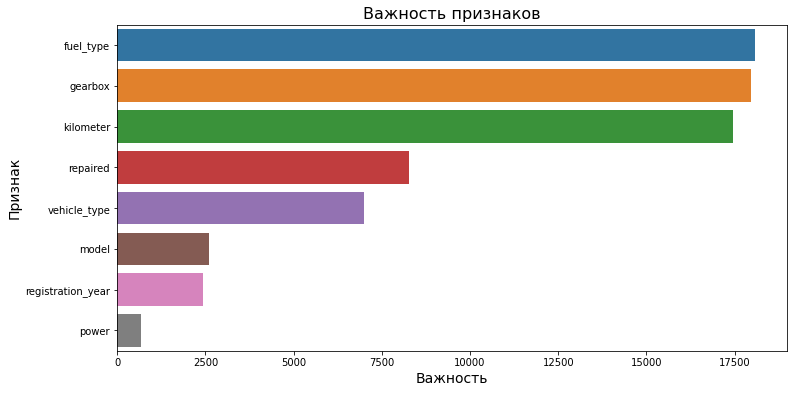

In [74]:
#построим столбчатый график
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='Importance', y='Feature', data=feature_importances)
ax.set_title('Важность признаков', fontsize=16)
ax.set_xlabel('Важность', fontsize=14)
ax.set_ylabel('Признак', fontsize=14)
plt.show()

Можно отметить, что самыми важными признаками при прогнозе стоимости автомобиля модель LightGBM посчитала: тип топлива, тип коробки передач и пробег. Наименее важные признаки - мощность и модель с годом регистрации. 

## Вывод

1. В первой части работы загрузили данные, обнаружили пропуски в пяти столбцах. На пропуски была поставлена заглушка для последующего анализа. Аномальные нулевые значения в столбцах со значениями цены были устранены, выбросы в столбце с мощностью заменили на медиану значений, отфильтровали данные по значению года регистрации - удалили очень старые или слишком новые по году выпуска машины  

Удалили неинформативные и не влияющие на стоимость машины признаки со значениями количества фотографий, даты скачивания анкеты из базы, даты последней активности пользователя, почтового индекс пользователя, месяца регистрации и даты создания анкеты.

Признаки бренд и модель машины объединили, так как они были мультиколлинеарными.

Удалили дубликаты данных.
Общий объем удаленных данных 18,3%

2. Обучили три модели - DecisionTreeRegressor, LightGBM и CatBoost. С помощью подбора гиперпараметров и GridSearchCV рассчитали метрики RMSE и лучшие параметры для трех моделей. 

3. Проанализировали скорость работы трех моделей. Модель дерева решений работает в разы быстрее, но показывает худшие показатели по метрике RMSE, в отличие от LightGBM и CatBoost. Лучший показатель по метрике RMSE у модели LightGBM.

По двум показателям из трех дерево решений показывает себя лучше всех - но выберем как лучшую модель LightGBM - по метрике RMSE и по неплохому результату скорости обучения и предсказания.

Качество лучшей модели на тестовых данных - 1513.76

4. По графику важности признаков выделили, что самыми важными признаками при прогнозе стоимости автомобиля модель LightGBM посчитала: тип топлива, тип коробки передач и пробег. Наименее важные признаки - мощность и модель с годом регистрации. 